In [1]:
import pickle
import numpy as np
import os
import gzip
import matplotlib.pyplot as plt

from model import Model
from utils import *
# from tensorboard_evaluation import Evaluation

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def read_data(datasets_dir="./data", frac = 0.1):
    """
    This method reads the states and actions recorded in drive_manually.py 
    and splits it into training/ validation set.
    """
    
    print("... read data")
    data_file = os.path.join(datasets_dir, 'data.pkl.gzip')
    
    f = gzip.open(data_file,'rb')
    data = pickle.load(f)
    
    # get images as features and actions as targets
    X = np.array(data["state"]).astype('float32')
    y = np.array(data["action"]).astype('float32')
    
    n_samples = len(data["state"])
    X_train, y_train = X[:int((1-frac) * n_samples)], y[:int((1-frac) * n_samples)]
    X_valid, y_valid = X[int((1-frac) * n_samples):], y[int((1-frac) * n_samples):]
    
    return X_train, y_train, X_valid, y_valid

def preprocess_X_for_conv(X, h):
    zeros = np.zeros((h-1, 96, 96))
    
    new_X_train = np.concatenate((zeros, X))
    new_X_list = []
    
    for i in range(X.shape[0]):
        new_X_list.append(new_X_train[i: i+h])
    
    new_X_train = np.array(new_X_list)
    
    return new_X_train

def preprocessing(X_train, y_train, X_valid, y_valid, h=1):
    # TODO: preprocess your data here.
    # 1. convert the images in X_train/X_valid to gray scale. If you use rgb2gray() from utils.py, the output shape (96, 96, 1)
    # 2. you can either train your model with continous actions (as you get them from read_data) using regression
    #    or you discretize the action space using action_to_id() from utils.py. If you discretize them, you'll maybe find one_hot() 
    #    useful and you may want to return X_train_unhot ... as well.
    # 
    # # History:
    # At first you should only use the current image as input to your network to learn the next action. Then the input states
    # have shape (96, 96,1). Later, add a history of the last N images to your state so that a state has shape (96, 96, N).
    X_train = rgb2gray(X_train)
    X_valid = rgb2gray(X_valid)
    
    X_train = preprocess_X_for_conv(X_train, h)
    X_valid = preprocess_X_for_conv(X_valid, h)
    
    return X_train, y_train, X_valid, y_valid



In [3]:

def train_model(X_train, y_train, X_valid, y_valid, n_minibatches, batch_size, lr, model_dir="./models", tensorboard_dir="./tensorboard"):
    
    # create result and model folders
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    if not os.path.exists(tensorboard_dir):
        os.mkdir(tensorboard_dir)
 
    print("... train model")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_dataset = TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).float())
    val_dataset = TensorDataset(torch.Tensor(X_valid).float(), torch.Tensor(y_valid).float())
    train_loader = DataLoader(
        train_dataset,
        batch_size = batch_size
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size = batch_size
    )

    agent = Model()
    agent.model = agent.model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(agent.model.parameters(), lr = lr)

    train_losses = []
    val_losses = []
    for epoch in range(n_minibatches):
        # print(f'-- running epoch {epoch + 1} --')
        
        total_train_loss = 0
        count = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = agent.model(X)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += float(loss) * X.shape[0]
            count += X.shape[0]
        
        avg_train_loss = total_train_loss / count


        with torch.no_grad():
            total_val_loss = 0
            count = 0
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                out = agent.model(X)
                loss = criterion(out, y)

                total_val_loss += float(loss) * X.shape[0]
                count += X.shape[0]
            
            avg_val_loss = total_val_loss / count


        print(f'epoch = {epoch}, train_loss = {avg_train_loss}, val_loss = {avg_val_loss}')
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
    # TODO: save your agent
    model_dir = agent.save(os.path.join(model_dir, "agent.ckpt"))
    print("Model saved in file: %s" % model_dir)


In [4]:
X_train, y_train, X_valid, y_valid = read_data("/scratch/prs392/data")
X_train, y_train, X_valid, y_valid = preprocessing(X_train, y_train, X_valid, y_valid, h=3)

# train model (you can change the parameters!)
train_model(X_train, y_train, X_valid, y_valid, n_minibatches=10, batch_size=64, lr=0.0001)
 


... read data
... train model
epoch = 0, train_loss = 0.10781574637360043, val_loss = 0.1342681366801262
epoch = 1, train_loss = 0.07497666254474057, val_loss = 0.1333034808933735
epoch = 2, train_loss = 0.06132689873667227, val_loss = 0.13118541526794433
epoch = 3, train_loss = 0.048650114061931767, val_loss = 0.14240537291765212
epoch = 4, train_loss = 0.04744709862603082, val_loss = 0.14270586037635805
epoch = 5, train_loss = 0.04543609856400225, val_loss = 0.14148288178443907
epoch = 6, train_loss = 0.04201823214027617, val_loss = 0.13455286806821823
epoch = 7, train_loss = 0.04063013125128216, val_loss = 0.13963985973596574
epoch = 8, train_loss = 0.03944381321138806, val_loss = 0.13775682279467583
epoch = 9, train_loss = 0.03741486017240418, val_loss = 0.15328693425655365
Model saved in file: None


In [5]:
X_train.shape

(18000, 3, 96, 96)

In [ ]:
# import seaborn as sns

# sns.set_style('darkgrid')
# epoch_df = pd.DataFrame(
#     data = zip(list(
#         range(1, 101), 
#         train_losses,
#         val_losses
#     )),
#     columns = ['epoch', 'train_loss', 'val_loss']
# )
# sns.lineplot(data=epoch_df, x="epoch", y="train_loss")
# sns.lineplot(data=epoch_df, x="epoch", y="val_loss")

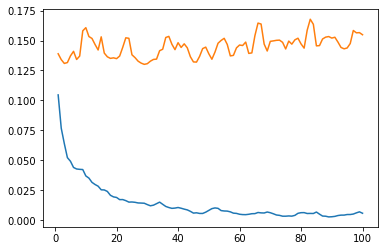

In [26]:
plt.plot(list(range(1, 101)), train_losses)
plt.plot(list(range(1, 101)), val_losses)`

In [19]:
!pwd

/home/ns4486/repos/deep-rl/hw/hw1


In [58]:
a = np.random.randn(10, 2, 2)

In [ ]:
b.shape

In [48]:
a

array([[[-1.55325184,  0.41584114],
        [-1.00596372,  0.0322054 ]],

       [[ 0.1620762 , -1.08385594],
        [-0.13188478,  0.90755748]],

       [[-1.08576933, -0.45324355],
        [-0.99222878,  0.22658862]],

       [[ 0.72281332, -0.45239166],
        [ 2.20282897, -0.08389351]],

       [[-1.19122789,  1.46680402],
        [-0.13298913,  2.38555102]],

       [[ 0.98160193, -1.3673283 ],
        [ 0.27645605,  1.01362348]],

       [[-0.81835741, -2.05078937],
        [ 1.00554501,  2.70707119]],

       [[-0.17791448,  0.706214  ],
        [-0.31733533, -0.72234224]],

       [[-1.07328592,  0.63158903],
        [ 1.08996035, -1.45583752]],

       [[ 0.15137742, -0.10050063],
        [-0.52811123, -1.04970501]]])

In [49]:
b

array([[[[-1.55325184,  0.1620762 , -1.08576933,  0.72281332,
          -1.19122789],
         [ 0.41584114, -1.08385594, -0.45324355, -0.45239166,
           1.46680402]],

        [[-1.00596372, -0.13188478, -0.99222878,  2.20282897,
          -0.13298913],
         [ 0.0322054 ,  0.90755748,  0.22658862, -0.08389351,
           2.38555102]]],


       [[[ 0.1620762 , -1.08576933,  0.72281332, -1.19122789,
           0.98160193],
         [-1.08385594, -0.45324355, -0.45239166,  1.46680402,
          -1.3673283 ]],

        [[-0.13188478, -0.99222878,  2.20282897, -0.13298913,
           0.27645605],
         [ 0.90755748,  0.22658862, -0.08389351,  2.38555102,
           1.01362348]]],


       [[[-1.08576933,  0.72281332, -1.19122789,  0.98160193,
          -0.81835741],
         [-0.45324355, -0.45239166,  1.46680402, -1.3673283 ,
          -2.05078937]],

        [[-0.99222878,  2.20282897, -0.13298913,  0.27645605,
           1.00554501],
         [ 0.22658862, -0.08389351,  2.3

In [3]:
h = 10
X_train = np.random.rand(18000, 96, 96)
zeros = np.zeros((h-1, 96, 96))
    
new_X_train = np.concatenate((zeros, X_train))
new_X_list = []

for i in range(X_train.shape[0]):
    new_X_list.append(new_X_train[i: i+h])

new_X_train = np.array(new_X_list)

In [4]:
X_train.shape

(18000, 96, 96)

In [14]:
X_train[1]

array([[0.64803264, 0.13856861, 0.59832251, ..., 0.6561182 , 0.41402695,
        0.86967027],
       [0.04576181, 0.58702148, 0.32174829, ..., 0.44582565, 0.09109458,
        0.94298839],
       [0.58510818, 0.71140923, 0.89659578, ..., 0.43496619, 0.46367226,
        0.78038551],
       ...,
       [0.19524167, 0.4549348 , 0.2571272 , ..., 0.60652776, 0.10684719,
        0.28140101],
       [0.23074009, 0.42635061, 0.23721206, ..., 0.84259511, 0.69937933,
        0.04211001],
       [0.92982291, 0.57028   , 0.32807038, ..., 0.30643142, 0.54061548,
        0.88450316]])

In [15]:
new_X_train.shape

(18000, 10, 96, 96)

In [16]:
new_X_train[1, -1]

array([[0.64803264, 0.13856861, 0.59832251, ..., 0.6561182 , 0.41402695,
        0.86967027],
       [0.04576181, 0.58702148, 0.32174829, ..., 0.44582565, 0.09109458,
        0.94298839],
       [0.58510818, 0.71140923, 0.89659578, ..., 0.43496619, 0.46367226,
        0.78038551],
       ...,
       [0.19524167, 0.4549348 , 0.2571272 , ..., 0.60652776, 0.10684719,
        0.28140101],
       [0.23074009, 0.42635061, 0.23721206, ..., 0.84259511, 0.69937933,
        0.04211001],
       [0.92982291, 0.57028   , 0.32807038, ..., 0.30643142, 0.54061548,
        0.88450316]])